In [1]:
import os
current_directory = os.getcwd()
import sys; sys.path.insert(0, current_directory)

In [2]:
import mne
import pickle as pkl
from copy import deepcopy
import os
import time
import numpy as np
from SimFunction import SimulationGenerator
from TimeCourses import TimeCourse
from invert.util import pos_from_forward
from scipy.spatial.distance import cdist
from IPython.display import Image, display

#### =========================================================================
#### Section 1: Setup and Loading the Forward Model
#### This section loads the pre-computed forward model and sensor information,
#### which are essential for linking brain source activity to sensor signals.
#### It also defines a helper function to save data and creates a directory
#### to store the simulation outputs.
#### =========================================================================
#### Specify the path to the directory containing the files

In [3]:
file_path = "forward_models"
folder_path = os.path.join(file_path, "128_ch_coarse_80_ratio-fwd.fif")
folder_path

'forward_models\\128_ch_coarse_80_ratio-fwd.fif'

#### Read the forward solution from the specified file

In [4]:
fwd_for = mne.read_forward_solution(folder_path, verbose=0)
fwd_for = mne.convert_forward_solution(fwd_for, force_fixed=True)

fn = os.path.join(file_path, "128_ch_info.fif")
info = mne.io.read_info(fn)

    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]


#### Define a function to save the data

In [5]:
def save_data(data_dict, folder_path, filename):
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'wb') as f:
        pkl.dump(data_dict, f)

#### Define the folder path for Simulated Data

In [6]:
folder_name = "Simulated_Data"
folder_path = os.path.join(os.getcwd(), folder_name)
os.makedirs(folder_path, exist_ok=True)

#### =========================================================================
#### Section 2: Main Simulation Loop
#### This is the core of the script, where nested loops iterate through
#### different experimental conditions like source correlation, spatial smoothness,
#### patch complexity (Patchranks), and signal-to-noise ratio (SNR).
#### For each combination of parameters, it generates and saves a batch of data.
#### =========================================================================

In [ ]:
batch_size = 50 # number of monte-carlo repettions 
Patchranks_Full = [[1, 2]]
for corr_coeff in [0.5]:
    for Smoothness_order in range(2,4,2):        
        for Patchranks in Patchranks_Full:                        
            for snr_db in range(-5,10,5): 
                start_time = time.time()  # Record start time

                # =====================================================
                # Subsection 2.1: Set Simulation Parameters
                # Inside the loop, this block sets up the specific
                # parameters for the current simulation run, such as
                # the size of the brain patch, number of time points,
                # and SNR level.
                # =====================================================

                TrueSour_Extent = 5 # Neighborhood orders (source extent)              
                maxPatchRank =  np.sum(Patchranks)+1 
                n_orders = TrueSour_Extent + 3 # check upto this order
                snr_abs = 10**(snr_db/10)
                n_timepoints = 50
                n_jobs = 7
                n_reg_params = 25
                smoothing_steps = 1 # just for plot
                random_seed = 42 #42
                Pert = 70
                Singsum = "False" 
                diffusion_parameter = 0.1                    
                        
                # =====================================================
                # Subsection 2.2: Generate Simulated Data
                # This block uses the custom `TimeCourse` and
                # `SimulationGenerator` classes to create the synthetic
                # brain activity. It first generates the source time
                # courses with a specific correlation and then uses the
                # generator to produce the final sensor-level data (Y)
                # and the true underlying source activity (SFull, etc.).
                # =====================================================

                # Default parameters (Don't change)
                generator_args_baseline = dict(
                    use_cov = False,
                    n_timecourses=5000,
                    return_mask = False, 
                    n_sources = 2,   # 2 simultaneous sources
                    n_orders = 0,  # Neighborhodd orders (source extent)
                    snr_range = (1,1),  # Signal-to-noise ratio (actual ratio, not dB)
                    amplitude_range = (0.5, 1),  # Range of source time course gain 
                    batch_size = 1,  # No. of samples or iterations
                    scale_data = False,  
                    n_timepoints = 50,  # No. of time points per sample
                    beta_range = (1 ,1),  # Determines the frequency spectrum of each simulted time course (1/f**beta)
                    return_info = True,  # Return information on the simulated sources
                    inter_source_correlation = 0.5,  # Inter source correlation coefficient roh
                    diffusion_parameter = 0.1,  # Diffusion parameter alpha: determines the speed of diffusion, thus shape of extended sources
                    random_seed=random_seed,  # Random seed for replicability
                    iid_noise=True)  # Sensor noise is IID, so not correlated among channels
            
                generator_args = deepcopy(generator_args_baseline) # make modification to generator_args dictionary without affecting generator_args_baseline
                generator_args["snr_range"] = (snr_abs, snr_abs)
                generator_args["n_sources"] = len(Patchranks)
                generator_args["batch_size"] = batch_size
                generator_args["n_timepoints"]=n_timepoints
                generator_args["n_orders"] = (0, TrueSour_Extent+1) # so if TrueSour_Extent=5, then n_orders = (5,6), which is just 5 only
                generator_args["return_info"]=True
                
                TimeCourses = []
                TimeCourses = TimeCourse(corr_coeff, batch_size, n_timepoints, np.sum(Patchranks), random_seed)
                print(np.corrcoef(TimeCourses[0], TimeCourses[1])[0,1])
                
                # Patch order are randomly generated in range (0,6)
                np.random.seed(random_seed)
                random_sequence = np.random.randint(0, TrueSour_Extent+1, size=1000)                
                
                gen_test = SimulationGenerator(fwd_for, TimeCourses, Patchranks, Smoothness_order, random_sequence, **generator_args)
                Y, KQFull, EFull, WFull, SFull, SdotFull, SddotFull, selection, sim_info = [], [], [], [], [], [], [], [], []
                Y, KQFull, EFull, WFull, SFull, SdotFull, SddotFull, selection, sim_info = next(gen_test) 
                
                # =====================================================
                # Subsection 2.3: Save Data to File
                # Here, all the generated data and corresponding
                # simulation parameters are bundled into a dictionary.
                # A descriptive filename is created, and the dictionary
                # is saved to a file using pickle for later analysis.
                # =====================================================

                # Inside your loop where you generate data, save it along with other variables
                data_dict = {}
                data_dict['corr_coeff'] = corr_coeff
                data_dict['Smoothness_order'] = Smoothness_order
                data_dict['Patchranks'] = Patchranks
                data_dict['snr_db'] = snr_db
                data_dict['Y'] = Y
                # data_dict['AAmp'] = AAmp
                # data_dict['SS'] = SS
                data_dict['selection'] = selection
                # data_dict['ssss'] = ssss
                # data_dict['TrueVLoc'] = TrueVLoc
                data_dict['TimeCourses'] = TimeCourses
                data_dict['sim_info'] = sim_info
                data_dict['KQFull'] = KQFull
                data_dict['EFull'] = EFull
                data_dict['WFull'] = WFull
                data_dict['SFull'] = SFull
                data_dict['SdotFull'] = SdotFull
                data_dict['SddotFull'] = SddotFull
                
                
                # Save the dictionary
                filename = f"Data_corr_{corr_coeff}_smooth_{Smoothness_order}_patchranks_{Patchranks}_snr_{snr_db}.pkl"
                save_data(data_dict, folder_path, filename)
                
                end_time = time.time()  # Record end time
                elapsed_time = end_time - start_time
                print(f"Elapsed time for corr_coeff={corr_coeff}, Smoothness_order={Smoothness_order}, Patchranks={Patchranks}, snr_db={snr_db}: {elapsed_time} seconds")


0.5143683160753044
Elapsed time for corr_coeff=0.5, Smoothness_order=2, Patchranks=[1, 2], snr_db=-5: 57.22281217575073 seconds
0.5143683160753044
Elapsed time for corr_coeff=0.5, Smoothness_order=2, Patchranks=[1, 2], snr_db=0: 44.64699935913086 seconds
0.5143683160753044
Elapsed time for corr_coeff=0.5, Smoothness_order=2, Patchranks=[1, 2], snr_db=5: 42.46954035758972 seconds


#### =========================================================================
#### Section 3: Plot Simulated Brain Activity
#### After the simulations are complete, this final section visualizes the
#### ground truth source activity. It loops through the results of the last
#### generated batch, creates an MNE SourceEstimate object for each sample,
#### and plots it on a 3D brain model, saving each plot as an image file.
#### =========================================================================

Using pyvistaqt 3d backend.
Using control points [ 0.12949039  1.61262166 41.39080748]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


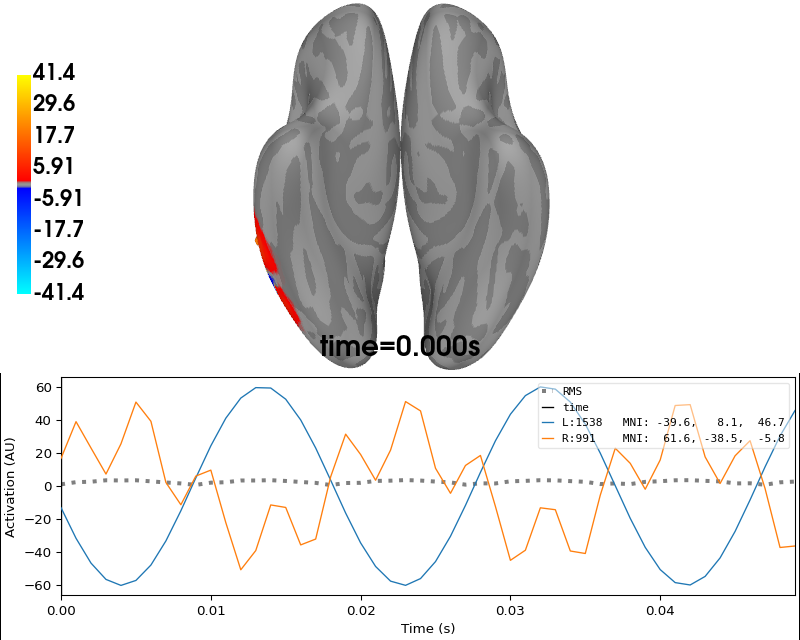

Using control points [ 1.81691244  5.50769537 48.77560349]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


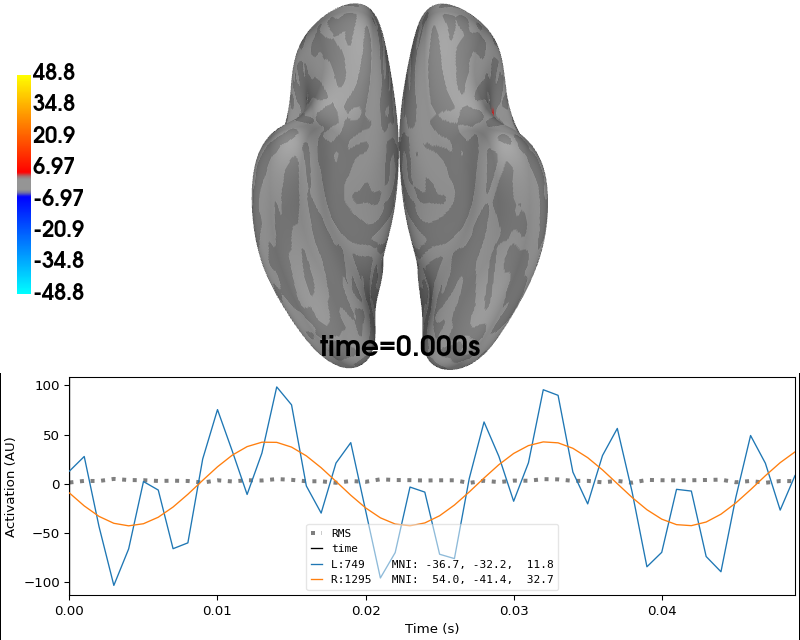

Using control points [ 0.          0.         27.03201647]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


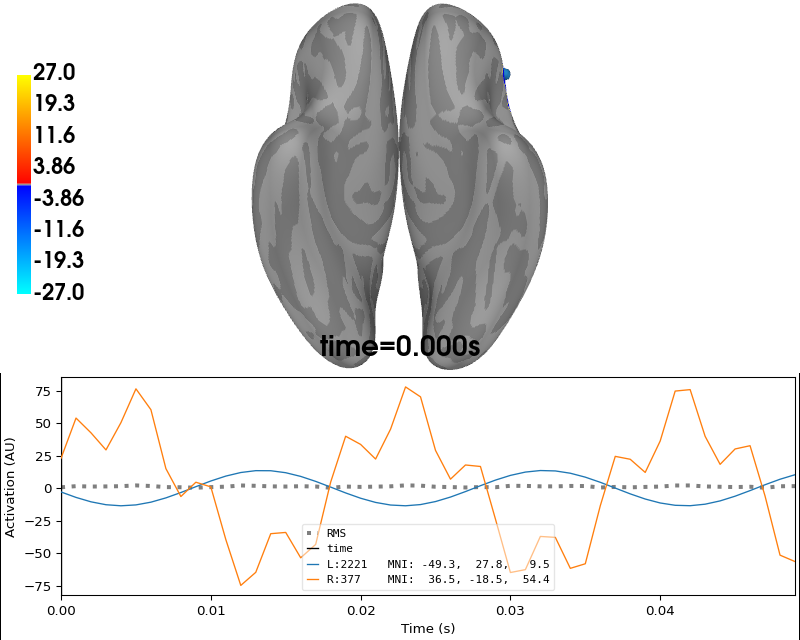

Using control points [ 1.49164592  6.56077462 63.19758254]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


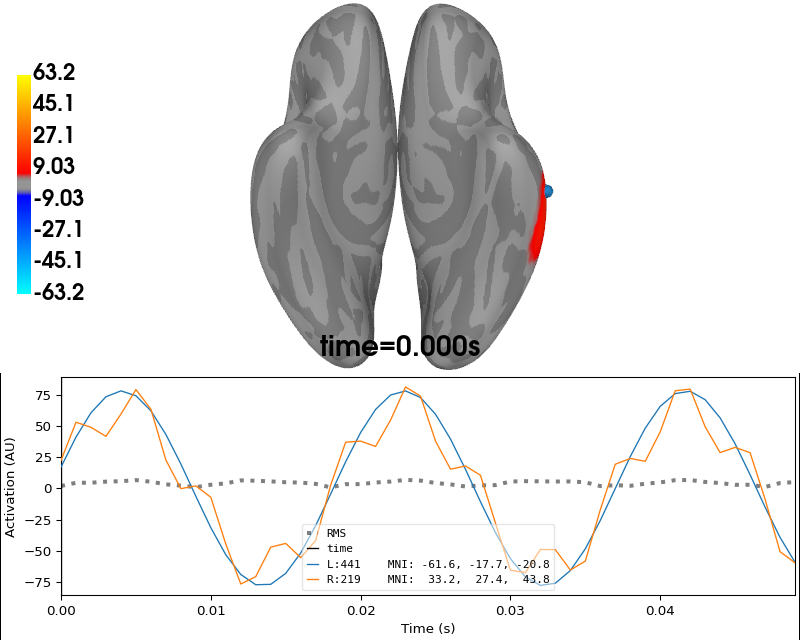

Using control points [ 1.54671968  5.71413409 58.27870999]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


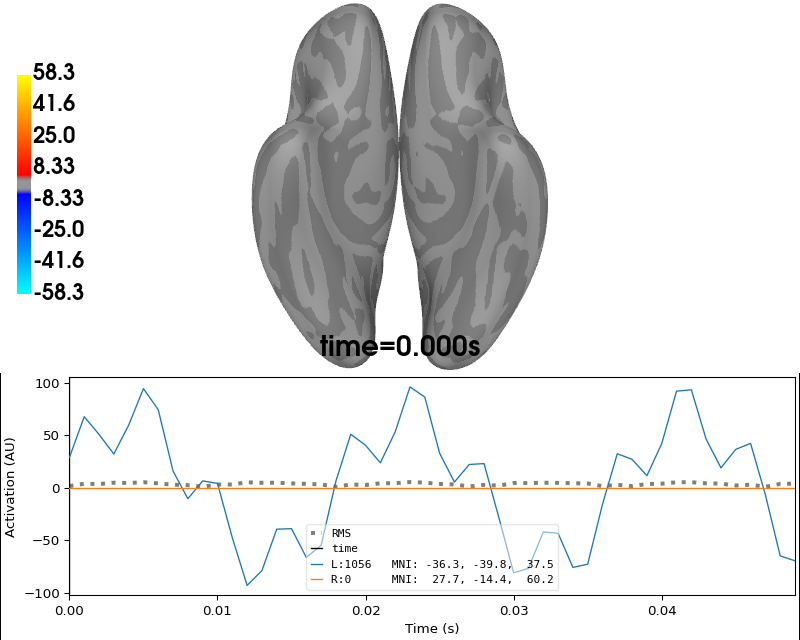

Using control points [ 0.          0.         20.98773488]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


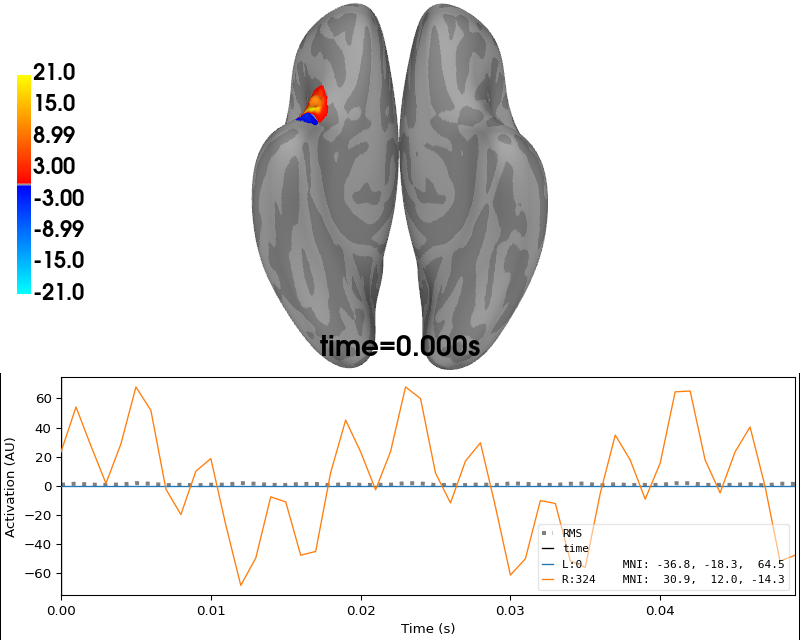

Using control points [ 0.          0.         25.97742988]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


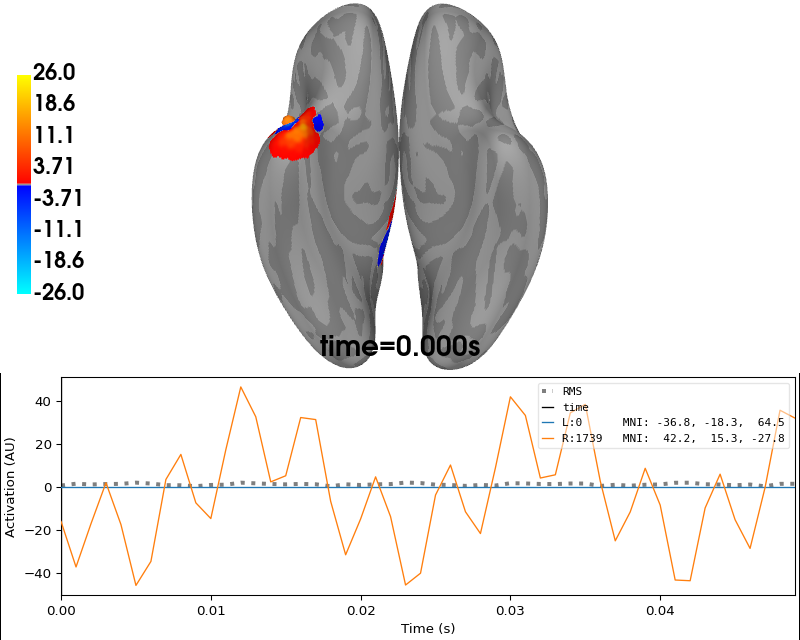

Using control points [ 0.          0.         28.65157893]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


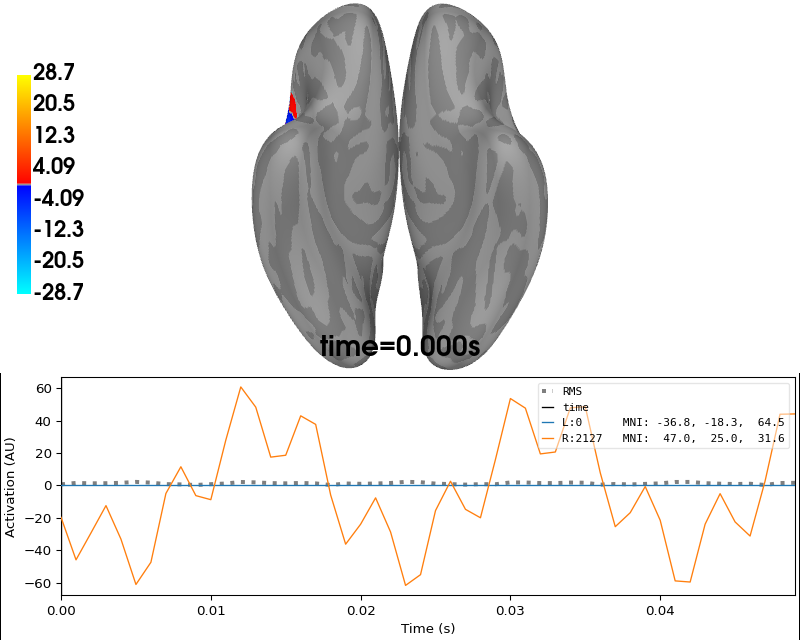

Using control points [ 0.          0.         35.79268069]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


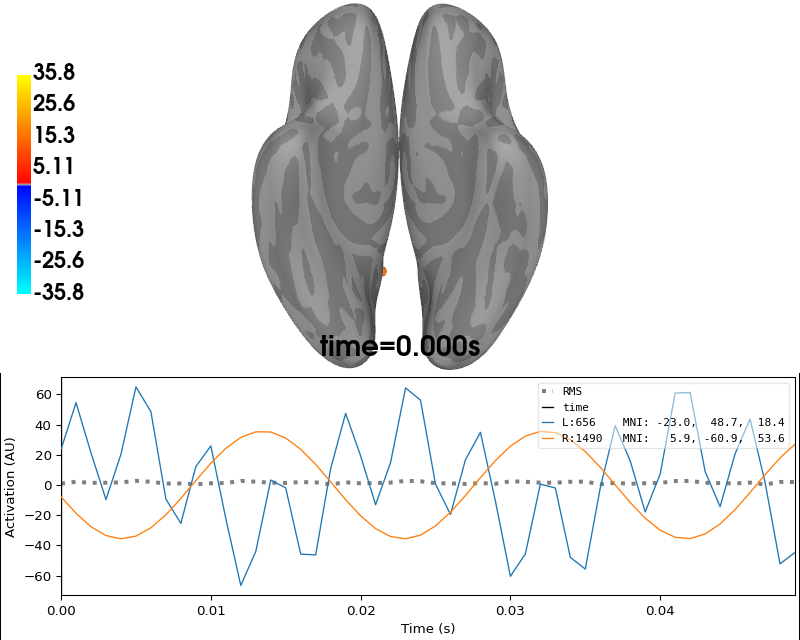

Using control points [ 2.27823004  7.828264   69.94602434]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


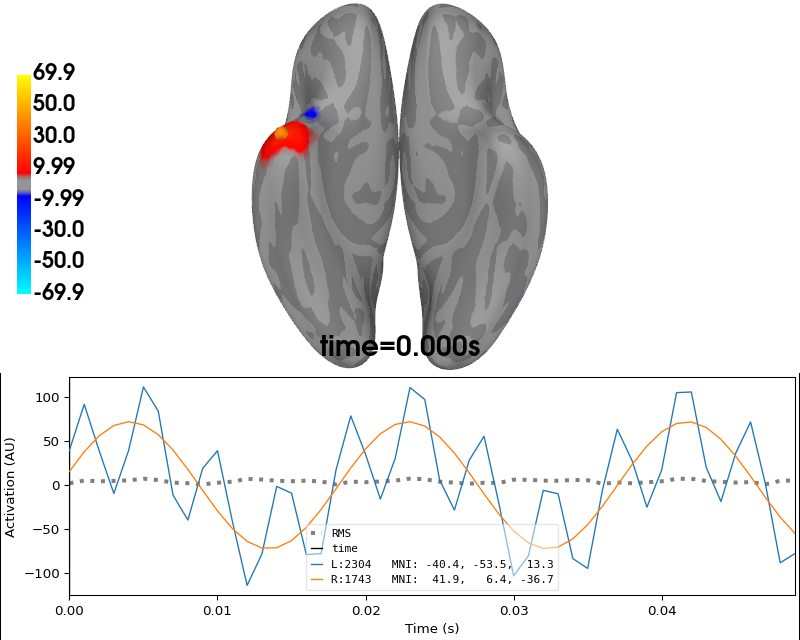

Using control points [ 0.08167196  1.34165043 48.14119519]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


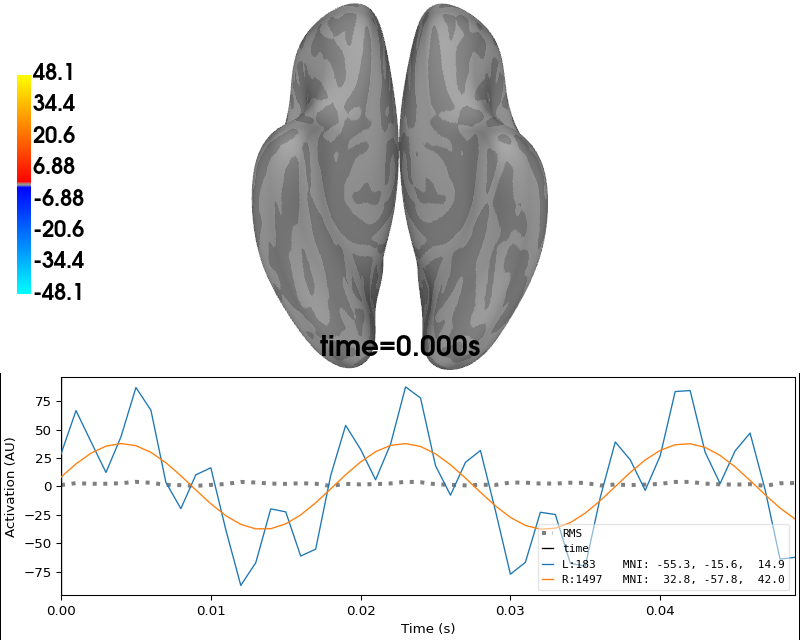

Using control points [ 0.          0.         27.40558894]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


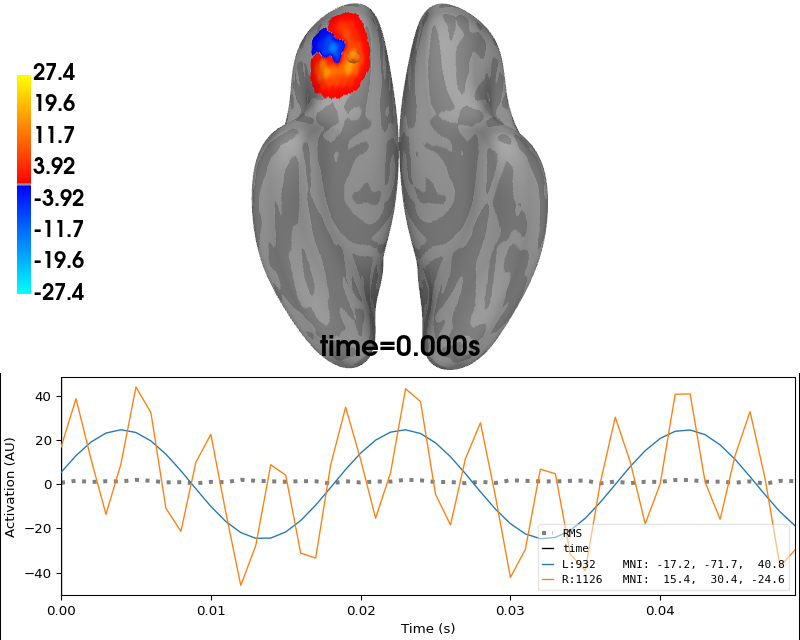

Using control points [ 5.5355544  13.15421376 83.37599555]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


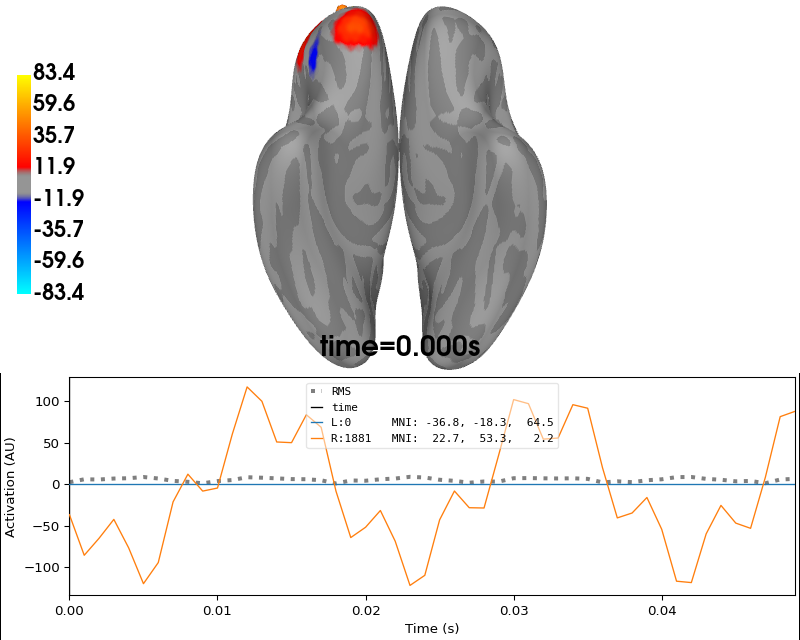

Using control points [ 1.50542537  5.60163776 57.30262405]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


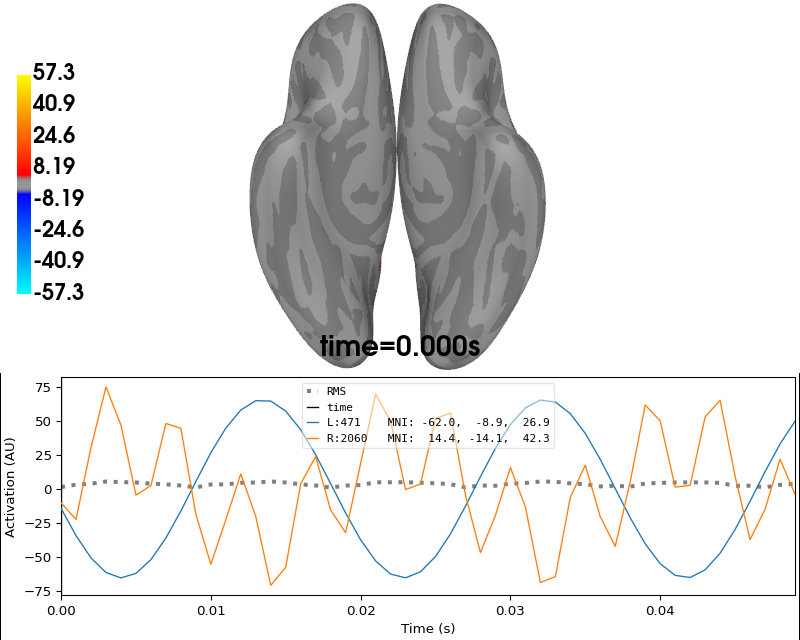

Using control points [ 0.          0.         13.18031174]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


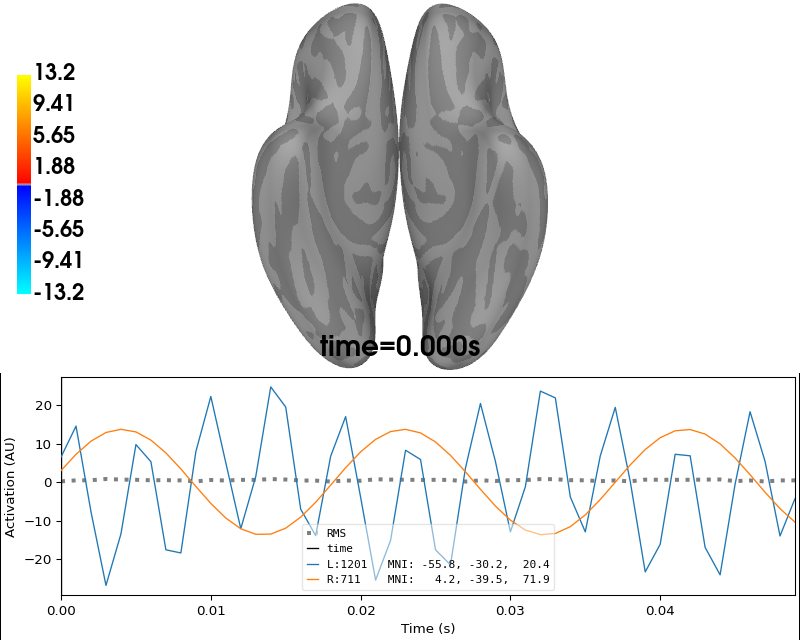

Using control points [ 0.15549065  1.37752124 41.76071165]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


: 

In [8]:
pp = dict(surface='inflated', hemi='both', background="white", verbose=0, colorbar=False, time_viewer=False)
pos_for = pos_from_forward(fwd_for)
source_model = fwd_for['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]
distances = cdist(pos_for, pos_for)
argsorted_distance_matrix = np.argsort(distances, axis=1)
subject = "fsaverage"
for i in range(0,batch_size):   
    subject = "fsaverage"        

    # Sum the activity from all sources for visualization

    # SS = np.add(SddotFull[i][0], SddotFull[i][1])
    SS = np.sum(SddotFull[i], axis=0)
    tmin = 0
    tstep = 1/1000  
    stc = mne.SourceEstimate(SS, vertices, tmin=tmin, tstep=tstep, 
                                subject=subject, verbose=0)
        
    stc_ = stc.copy()
    stc_.data = SS #abs(stc_.data / np.max(stc_.data, axis=0))
        
    # Plot the source activity on the brain
    
    brain = stc_.plot(
        hemi="both",
        views=["ven"],
        brain_kwargs=dict(title="Simulated Source Activity"),
        colorbar=True,
        cortex="low_contrast",
        background="white",
    )     
    brain.save_image("source_plot_{}.png".format(i))
    display(Image("source_plot_{}.png".format(i)))